## This notebook shows how to use Orchestrator APIs for user experiments

In [2]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [3]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: cm.fabric-testbed.net Orchestrator Host: orchestrator.fabric-testbed.net


In [4]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

In [5]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: NCSA: { cpu: 6/6 , core: 172/192 , ram: 1,448/1,536 G, disk: 60,310/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 8,640/9,600 G, unit: 9/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 0/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 375/381 }
	Site Interfaces:
		NCSA_STAR: TrunkPort { bw: 100/100 Gbps}
TACC: { cpu: 10/10 , core: 320/320 , ram: 2,560/2,560 G, disk: 116,400/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 4/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 635/635 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
	Site Interfaces:
		TACC_UTAH: TrunkPort { 

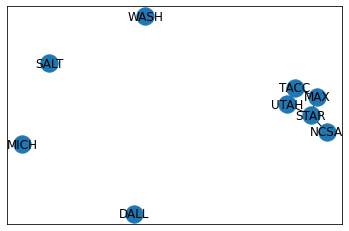

In [6]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

In [8]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()


# Add node
n1 = t.add_node(name='master_node', site='MAX')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=4, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Add node
n2 = t.add_node(name='client_node', site='MAX')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


# Generate Slice Graph
slice_graph = t.serialize()

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-Kubernetes-Hello-World', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "82a16173-b871-4705-8e15-154ca5aa3526",
    "lease_end": "2021-11-22 19:23:09",
    "pending_state": "None_",
    "reservation_id": "6d14288f-a57c-4b7f-9c56-1d8be60e4d71",
    "reservation_state": "Unknown",
    "slice_id": "b4f605c8-6974-482d-a7fb-c0c6c3109108"
}, {
    "graph_node_id": "7b60a476-fcc6-40ee-9780-8c0d3a185736",
    "lease_end": "2021-11-22 19:23:09",
    "pending_state": "None_",
    "reservation_id": "ff62edac-e82a-41f4-93a1-8e150d9d4e96",
    "reservation_state": "Unknown",
    "slice_id": "b4f605c8-6974-482d-a7fb-c0c6c3109108"
}]


In [12]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id
print(slice_id)

b4f605c8-6974-482d-a7fb-c0c6c3109108


## Query Slices

In [13]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "f1d68ad0-48ae-4f09-a051-369caed22446",
    "lease_end": "2021-11-21 01:22:55",
    "slice_id": "8ef39ae0-9ccd-40e8-992a-2497b01f5341",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Dead"
}, {
    "graph_id": "44625d85-ad4a-4c80-bb27-c3f810735c06",
    "lease_end": "2021-11-17 07:00:32",
    "slice_id": "7bb8c733-e0f8-4a0b-abaf-4b433ab66167",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Dead"
}, {
    "graph_id": "a161a769-0f89-43b0-bfe2-396c256baa25",
    "lease_end": "2021-11-22 19:23:09",
    "slice_id": "b4f605c8-6974-482d-a7fb-c0c6c3109108",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "StableOK"
}]


## Query Slivers

In [14]:
slice_object = list(filter(lambda x: x.slice_id == slice_id, slices))[0]
status, slivers = slice_manager.slivers(slice_object=slice_object)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000006aa\", \"instance_parent\": \"max-w4.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 4}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "82a16173-b871-4705-8e15-154ca5aa3526",
    "join_state": "NoJoin",
    "lease_end": "2021-11-22 19:23:09",
    "management_ip": "63.239.135.120",
    "name": "master_node",
    "notices": "Reservation 6d14288f-a57c-4b7f-9c56-1d8be60e4d71 (Slice Slice-Kubernetes-Hello-World(b4f605c8-6974-482d-a7fb-c0c6c3109108) Graph Id:a161a769-0f89-43b0-bfe2-396c256baa25 Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_state": "None_",
    "reservation_id": "6d14288f-a57c-4b7f

## Sliver Status

In [15]:
for s in slivers:
    status, sliver_status = slice_manager.sliver_status(sliver=s)

    print("Response Status {}".format(status))
    if status == Status.OK:
        print()
        print("Sliver Status {}".format(sliver_status))
        print()

Response Status Status.OK

Sliver Status {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000006aa\", \"instance_parent\": \"max-w4.fabric-testbed.net\"}",
    "capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 4}",
    "capacity_hints": "{\"instance_type\": \"fabric.c2.m8.d10\"}",
    "graph_node_id": "82a16173-b871-4705-8e15-154ca5aa3526",
    "join_state": "NoJoin",
    "lease_end": "2021-11-22 19:23:09",
    "management_ip": "63.239.135.120",
    "name": "master_node",
    "notices": "Reservation 6d14288f-a57c-4b7f-9c56-1d8be60e4d71 (Slice Slice-Kubernetes-Hello-World(b4f605c8-6974-482d-a7fb-c0c6c3109108) Graph Id:a161a769-0f89-43b0-bfe2-396c256baa25 Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_state": "None_",
    "reservation_id": "6d14288f-a57

## Work on the servers starts here.

### We are going to use paramiko to connect to our servers through ssh.

In [16]:
import paramiko

### We have two servers with two IPs.

In [17]:
master_node_ip = list(filter(lambda sliver : sliver.name == "master_node",slivers))[0].management_ip
master_node_ip

'63.239.135.120'

In [18]:
client_node_ip = list(filter(lambda sliver : sliver.name == "client_node",slivers))[0].management_ip
client_node_ip

'63.239.135.114'

### Below, we connect to some nodes.

In [19]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
master_node = paramiko.SSHClient()
master_node.load_system_host_keys()
master_node.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

master_node.set_missing_host_key_policy(paramiko.AutoAddPolicy())
master_node.connect(master_node_ip,username='ubuntu',pkey = key)

master_node

In [20]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client_node = paramiko.SSHClient()
client_node.load_system_host_keys()
client_node.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client_node.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client_node.connect(client_node_ip,username='ubuntu',pkey = key)

client_node

### Connection should be established. Let's issue some test commands:

In [21]:
stdin, stdout, stderr = master_node.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.3 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [22]:
stdin, stdout, stderr = master_node.exec_command('ip addr')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:a4:2c:ba brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.174/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86252sec preferred_lft 86252sec
    inet6 fe80::f816:3eff:fea4:2cba/64 scope link 
       valid_lft forever preferred_lft forever




In [23]:
stdin, stdout, stderr = master_node.exec_command('curl https://ipinfo.io/ip')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

63.239.135.120
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     90      0 --:--:-- --:--:-- --:--:--    90



### Now, let's do a quick ping experiment. Let's let each of the servers ping the other server.

In [24]:
stdin, stdout, stderr = client_node.exec_command('ping -c 10 ' + master_node_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.120 (63.239.135.120) 56(84) bytes of data.
64 bytes from 63.239.135.120: icmp_seq=1 ttl=63 time=0.487 ms
64 bytes from 63.239.135.120: icmp_seq=2 ttl=63 time=0.558 ms
64 bytes from 63.239.135.120: icmp_seq=3 ttl=63 time=0.399 ms
64 bytes from 63.239.135.120: icmp_seq=4 ttl=63 time=0.383 ms
64 bytes from 63.239.135.120: icmp_seq=5 ttl=63 time=0.345 ms
64 bytes from 63.239.135.120: icmp_seq=6 ttl=63 time=0.336 ms
64 bytes from 63.239.135.120: icmp_seq=7 ttl=63 time=0.303 ms
64 bytes from 63.239.135.120: icmp_seq=8 ttl=63 time=0.305 ms
64 bytes from 63.239.135.120: icmp_seq=9 ttl=63 time=0.348 ms
64 bytes from 63.239.135.120: icmp_seq=10 ttl=63 time=0.350 ms

--- 63.239.135.120 ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9211ms
rtt min/avg/max/mdev = 0.303/0.381/0.558/0.077 ms




In [25]:
stdin, stdout, stderr = master_node.exec_command('ping -c 10 ' + client_node_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.114 (63.239.135.114) 56(84) bytes of data.
64 bytes from 63.239.135.114: icmp_seq=1 ttl=63 time=0.201 ms
64 bytes from 63.239.135.114: icmp_seq=2 ttl=63 time=0.375 ms
64 bytes from 63.239.135.114: icmp_seq=3 ttl=63 time=0.277 ms
64 bytes from 63.239.135.114: icmp_seq=4 ttl=63 time=0.273 ms
64 bytes from 63.239.135.114: icmp_seq=5 ttl=63 time=0.286 ms
64 bytes from 63.239.135.114: icmp_seq=6 ttl=63 time=0.269 ms
64 bytes from 63.239.135.114: icmp_seq=7 ttl=63 time=0.238 ms
64 bytes from 63.239.135.114: icmp_seq=8 ttl=63 time=0.258 ms
64 bytes from 63.239.135.114: icmp_seq=9 ttl=63 time=0.320 ms
64 bytes from 63.239.135.114: icmp_seq=10 ttl=63 time=0.261 ms

--- 63.239.135.114 ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9195ms
rtt min/avg/max/mdev = 0.201/0.275/0.375/0.044 ms




### Ping experiment complete. Both nodes can see each other.

### Now, let's start a Kubernetes cluster on those two nodes.

We follow the instructions that we have here: https://github.com/apache/openwhisk-deploy-kube/blob/master/docs/k8s-diy-ubuntu.md

## Master node setup.

We now simply follow the instructions on our master node one by one.

In [26]:
stdin, stdout, stderr = master_node.exec_command('sudo apt update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [987 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [184 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [8880 B]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [526 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [75.4 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [528 B]
Get:12 http://security.ubuntu.com/ubuntu focal-security/univer

In [27]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get install -y docker.io')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base libidn11 pigz runc
  ubuntu-fan
Suggested packages:
  ifupdown aufs-tools cgroupfs-mount | cgroup-lite debootstrap docker-doc
  rinse zfs-fuse | zfsutils
The following NEW packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base docker.io libidn11 pigz
  runc ubuntu-fan
0 upgraded, 9 newly installed, 0 to remove and 73 not upgraded.
Need to get 74.5 MB of archives.
After this operation, 361 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 pigz amd64 2.4-1 [57.4 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 bridge-utils amd64 1.6-2ubuntu1 [30.5 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 runc amd64 1.0.1-0ubuntu2~20.04.1 [4155 kB]
Get:4 http://nova.cloud

In [28]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get update && sudo apt-get install -y apt-transport-https curl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcurl4
The following NEW packages will be installed:
  apt-transport-https
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 1 newly installed, 0 to remove and 71 not upgraded.
Need to get 400 kB of archives.
After this operation, 164 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/universe amd64 apt-transport-https all 2.0.6 [4680 B]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.7 [161 kB]
Get:3 http://nova.cloud

In [29]:
stdin, stdout, stderr = master_node.exec_command('curl -s https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

OK




In [30]:
stdin, stdout, stderr = master_node.exec_command('cat <<EOF | sudo tee /etc/apt/sources.list.d/kubernetes.list\ndeb https://apt.kubernetes.io/ kubernetes-xenial main\nEOF\n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [31]:
stdin, stdout, stderr = master_node.exec_command('cat /etc/apt/sources.list.d/kubernetes.list')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [32]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Get:5 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [9383 B]
Get:6 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 Packages [51.6 kB]
Fetched 61.0 kB in 2s (37.8 kB/s)
Reading package lists...




In [33]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-get install -y kubelet=1.19.0-00 kubeadm=1.19.0-00 kubectl=1.19.0-00')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  conntrack cri-tools ebtables kubernetes-cni socat
Suggested packages:
  nftables
The following NEW packages will be installed:
  conntrack cri-tools ebtables kubeadm kubectl kubelet kubernetes-cni socat
0 upgraded, 8 newly installed, 0 to remove and 71 not upgraded.
Need to get 70.9 MB of archives.
After this operation, 297 MB of additional disk space will be used.
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 conntrack amd64 1:1.4.5-2 [30.3 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 ebtables amd64 2.0.11-3build1 [80.3 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 socat amd64 1.7.3.3-2 [323 kB]
Get:1 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 cri-tools amd64 1.19.0-00 [11.2 MB]
Get:2 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 ku

In [34]:
stdin, stdout, stderr = master_node.exec_command('sudo apt-mark hold kubelet kubeadm kubectl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

kubelet set on hold.
kubeadm set on hold.
kubectl set on hold.




In [35]:
stdin, stdout, stderr = master_node.exec_command('sudo swapoff -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### The setup part is complete. Now, we issue the kubeadm init command below:

In [36]:
stdin, stdout, stderr = master_node.exec_command('sudo kubeadm init --pod-network-cidr=192.168.0.0/16 --apiserver-advertise-address=0.0.0.0 --control-plane-endpoint=' + master_node_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

[init] Using Kubernetes version: v1.19.16
[preflight] Running pre-flight checks
[preflight] Pulling images required for setting up a Kubernetes cluster
[preflight] This might take a minute or two, depending on the speed of your internet connection
[preflight] You can also perform this action in beforehand using 'kubeadm config images pull'
[certs] Using certificateDir folder "/etc/kubernetes/pki"
[certs] Generating "ca" certificate and key
[certs] Generating "apiserver" certificate and key
[certs] apiserver serving cert is signed for DNS names [6d14288f-a57c-4b7f-9c56-1d8be60e4d71-master-node kubernetes kubernetes.default kubernetes.default.svc kubernetes.default.svc.cluster.local] and IPs [10.96.0.1 10.20.4.174 63.239.135.120]
[certs] Generating "apiserver-kubelet-client" certificate and key
[certs] Generating "front-proxy-ca" certificate and key
[certs] Generating "front-proxy-client" certificate and key
[certs] Generating "etcd/ca" certificate and key
[certs] Generating "etcd/server

### As stated, the initialization was successful. Note that we need to save the join command somewhere, because we will need to use it later at the client.

In [37]:
stdin, stdout, stderr = master_node.exec_command('mkdir -p $HOME/.kube')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [38]:
stdin, stdout, stderr = master_node.exec_command('sudo cp -i /etc/kubernetes/admin.conf $HOME/.kube/config')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [39]:
stdin, stdout, stderr = master_node.exec_command('sudo chown $(id -u):$(id -g) $HOME/.kube/config')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [40]:
stdin, stdout, stderr = master_node.exec_command('kubectl apply -f https://docs.projectcalico.org/manifests/calico.yaml')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

configmap/calico-config created
customresourcedefinition.apiextensions.k8s.io/bgpconfigurations.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/bgppeers.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/blockaffinities.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/caliconodestatuses.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/clusterinformations.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/felixconfigurations.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/globalnetworkpolicies.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/globalnetworksets.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/hostendpoints.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8s.io/ipamblocks.crd.projectcalico.org created
customresourcedefinition.apiextensions.k8

In [43]:
stdin, stdout, stderr = master_node.exec_command('kubectl get nodes')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME                                               STATUS   ROLES    AGE     VERSION
6d14288f-a57c-4b7f-9c56-1d8be60e4d71-master-node   Ready    master   7m35s   v1.19.0




## Client side setup.

### We are now done with the server. Let's do the client. Remember, we are following the instructions in the link that we have previously mentioned.

In [44]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://nova.clouds.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://nova.clouds.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://nova.clouds.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [1344 kB]
Get:12 http://nova.clouds.archiv

In [45]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get install -y docker.io')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base libidn11 pigz runc
  ubuntu-fan
Suggested packages:
  ifupdown aufs-tools cgroupfs-mount | cgroup-lite debootstrap docker-doc
  rinse zfs-fuse | zfsutils
The following NEW packages will be installed:
  bridge-utils containerd dns-root-data dnsmasq-base docker.io libidn11 pigz
  runc ubuntu-fan
0 upgraded, 9 newly installed, 0 to remove and 73 not upgraded.
Need to get 74.5 MB of archives.
After this operation, 361 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 pigz amd64 2.4-1 [57.4 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 bridge-utils amd64 1.6-2ubuntu1 [30.5 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 runc amd64 1.0.1-0ubuntu2~20.04.1 [4155 kB]
Get:4 http://nova.cloud

In [46]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get update && sudo apt-get install -y apt-transport-https curl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libcurl4
The following NEW packages will be installed:
  apt-transport-https
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 1 newly installed, 0 to remove and 71 not upgraded.
Need to get 400 kB of archives.
After this operation, 164 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/universe amd64 apt-transport-https all 2.0.6 [4680 B]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.7 [161 kB]
Get:3 http://nova.cloud

In [47]:
stdin, stdout, stderr = client_node.exec_command('curl -s https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

OK




In [48]:
stdin, stdout, stderr = client_node.exec_command('cat <<EOF | sudo tee /etc/apt/sources.list.d/kubernetes.list\ndeb https://apt.kubernetes.io/ kubernetes-xenial main\nEOF\n')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [49]:
stdin, stdout, stderr = client_node.exec_command('cat /etc/apt/sources.list.d/kubernetes.list')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

deb https://apt.kubernetes.io/ kubernetes-xenial main




In [50]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get update')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Get:4 https://packages.cloud.google.com/apt kubernetes-xenial InRelease [9383 B]
Get:6 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 Packages [51.6 kB]
Fetched 61.0 kB in 1s (46.8 kB/s)
Reading package lists...




In [51]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-get install -y kubelet=1.19.0-00 kubeadm=1.19.0-00 kubectl=1.19.0-00')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  conntrack cri-tools ebtables kubernetes-cni socat
Suggested packages:
  nftables
The following NEW packages will be installed:
  conntrack cri-tools ebtables kubeadm kubectl kubelet kubernetes-cni socat
0 upgraded, 8 newly installed, 0 to remove and 71 not upgraded.
Need to get 70.9 MB of archives.
After this operation, 297 MB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 conntrack amd64 1:1.4.5-2 [30.3 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 ebtables amd64 2.0.11-3build1 [80.3 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 socat amd64 1.7.3.3-2 [323 kB]
Get:3 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 cri-tools amd64 1.19.0-00 [11.2 MB]
Get:5 https://packages.cloud.google.com/apt kubernetes-xenial/main amd64 ku

In [52]:
stdin, stdout, stderr = client_node.exec_command('sudo apt-mark hold kubelet kubeadm kubectl')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

kubelet set on hold.
kubeadm set on hold.
kubectl set on hold.




In [53]:
stdin, stdout, stderr = client_node.exec_command('sudo swapoff -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### The setup part is complete. Now we need to do the join command. We do it like this:

As a note. When we do "kubeadm init" in the server, it prints the join command for us. What we do is that we copy it and paste it in the client. And don't forget to add sudo.

In [54]:
stdin, stdout, stderr = client_node.exec_command('sudo kubeadm join 63.239.135.120:6443 --token nhdhga.zib7pwcaiio87i71 --discovery-token-ca-cert-hash sha256:68f445d2c73ce211505ed76998aa300f6d73fac06284b5aee68077d7868df413')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

[preflight] Running pre-flight checks
[preflight] Reading configuration from the cluster...
[preflight] FYI: You can look at this config file with 'kubectl -n kube-system get cm kubeadm-config -oyaml'
[kubelet-start] Writing kubelet configuration to file "/var/lib/kubelet/config.yaml"
[kubelet-start] Writing kubelet environment file with flags to file "/var/lib/kubelet/kubeadm-flags.env"
[kubelet-start] Starting the kubelet
[kubelet-start] Waiting for the kubelet to perform the TLS Bootstrap...

This node has joined the cluster:
* Certificate signing request was sent to apiserver and a response was received.
* The Kubelet was informed of the new secure connection details.

Run 'kubectl get nodes' on the control-plane to see this node join the cluster.


	[WARNING IsDockerSystemdCheck]: detected "cgroupfs" as the Docker cgroup driver. The recommended driver is "systemd". Please follow the guide at https://kubernetes.io/docs/setup/cri/
	[WARNING SystemVerification]: this Docker version i

### Let's check back at the server.

In [56]:
stdin, stdout, stderr = master_node.exec_command('kubectl get nodes')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

NAME                                               STATUS   ROLES    AGE   VERSION
6d14288f-a57c-4b7f-9c56-1d8be60e4d71-master-node   Ready    master   10m   v1.19.0
ff62edac-e82a-41f4-93a1-8e150d9d4e96-client-node   Ready    <none>   44s   v1.19.0




### We can see that the worker node is connected. Task complete.

### In the next steps we set up slate.

In [57]:
stdin, stdout, stderr = master_node.exec_command("""echo '#!/bin/sh\nmkdir -p -m 0700 "$HOME/.slate"\nif [ "$?" -ne 0 ] ; then\n	echo "Not able to create $HOME/.slate" 1>&2\n	exit 1\nfi\n\necho "c5oJVWkNJLoZ5Qezh2UNQE" > "$HOME/.slate/token"\nif [ "$?" -ne 0 ] ; then\n	echo "Not able to write token data to $HOME/.slate/token" 1>&2\n	exit 1\nfi\nchmod 600 "$HOME/.slate/token"\necho \'https://api.slateci.io:443\' > ~/.slate/endpoint\necho "SLATE access token successfully stored"\n' > slatescript.sh""")
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [58]:
stdin, stdout, stderr = master_node.exec_command('chmod +x ./slatescript.sh')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [59]:
stdin, stdout, stderr = master_node.exec_command('./slatescript.sh')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

SLATE access token successfully stored




In [60]:
stdin, stdout, stderr = master_node.exec_command('curl -LO https://jenkins.slateci.io/artifacts/client/slate-linux.tar.gz')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1896k  100 1896k    0     0  3598k      0 --:--:-- --:--:-- --:--:-- 3591k



In [61]:
stdin, stdout, stderr = master_node.exec_command('tar xzf slate-linux.tar.gz')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [62]:
stdin, stdout, stderr = master_node.exec_command('sudo mv slate /usr/local/bin')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [63]:
stdin, stdout, stderr = master_node.exec_command('slate cluster list')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Name               Admin        ID
Fabric-UC          ssl          cluster_kX2kBShHJZU
Rice-CRC-OCI       rice-crc     cluster_wRzlo7q62VM
check-mk-test      cmk-um       cluster_QJaTB3nj5a8
chtc-tiger         chtc-osg     cluster_BhJeF1PCuro
clemson-aci        clemson-aci  cluster_btEVWqfo5R4
cluster1           g1           cluster_XgYfXrecuX8
cluster2           g1           cluster_XdX7679ReD8
frontera           tacc-admin   cluster_xyOjLBH8YFg
gpn-beocat         gpn-poc      cluster_YRl0CqESiJU
gpn-poc-onenet     gpn-poc      cluster_HuMFzohYwDA
gpn-poc-test       gpn-poc      cluster_jx9sSpVedOI
iu-osiris          osiris       cluster_biECfbqdj9g
mwt2-iu            mwt2         cluster_WMaDQIPYI2s
mwt2-iu-test       atlas-squid  cluster_mvO9QzLUj94
net2               net2         cluster_Z-gQFi1-O1Y
nmsu               nmsu         cluster_u5P6TmKkOU0
notredame          ndcms        cluster_ojX0uEdg9tc
osg-gatech-dev     gatech-dev   cluster_W_LeACXrMC8
prague-xcache      atlas-xcac

In [64]:
stdin, stdout, stderr = master_node.exec_command('kubectl create -f https://raw.githubusercontent.com/metallb/metallb/v0.10.2/manifests/namespace.yaml')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

namespace/metallb-system created




In [65]:
stdin, stdout, stderr = master_node.exec_command('kubectl create -f https://raw.githubusercontent.com/metallb/metallb/v0.10.2/manifests/metallb.yaml')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

podsecuritypolicy.policy/controller created
podsecuritypolicy.policy/speaker created
serviceaccount/controller created
serviceaccount/speaker created
clusterrole.rbac.authorization.k8s.io/metallb-system:controller created
clusterrole.rbac.authorization.k8s.io/metallb-system:speaker created
role.rbac.authorization.k8s.io/config-watcher created
role.rbac.authorization.k8s.io/pod-lister created
role.rbac.authorization.k8s.io/controller created
clusterrolebinding.rbac.authorization.k8s.io/metallb-system:controller created
clusterrolebinding.rbac.authorization.k8s.io/metallb-system:speaker created
rolebinding.rbac.authorization.k8s.io/config-watcher created
rolebinding.rbac.authorization.k8s.io/pod-lister created
rolebinding.rbac.authorization.k8s.io/controller created
daemonset.apps/speaker created
deployment.apps/controller created




In [66]:
stdin, stdout, stderr = master_node.exec_command('cat <<EOF > metallb-config.yaml\napiVersion: v1\nkind: ConfigMap\nmetadata:\n  namespace: metallb-system\n  name: config\ndata:\n  config: |\n    address-pools:\n    - name: default\n      protocol: layer2\n      addresses:\n      - 10.20.4.0-10.20.5.0\nEOF')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [67]:
stdin, stdout, stderr = master_node.exec_command('kubectl apply -f metallb-config.yaml')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

configmap/config created




In [68]:
stdin, stdout, stderr = master_node.exec_command('slate cluster create cluster3 --group g1 --org org1 -y')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Checking NRP-controller status...
It appears that the nrp-controller is not deployed on this cluster.

The nrp-controller is a utility which allows SLATE to operate with
reduced privileges in your Kubernetes cluster. It grants SLATE access to a
single initial namespace of your choosing and a mechanism to create additional
namespaces, without granting it any access to namespaces it has not created.
This means that you can be certain that SLATE will not interfere with other
uses of your cluster.
See https://gitlab.com/ucsd-prp/nrp-controller for more information on the
controller software and 
https://raw.githubusercontent.com/slateci/slate-client-server/master/resources/federation-deployment.yaml for the
deployment definition used to install it.

This component is needed for SLATE to use this cluster.
Do you want to install it now? [y]/n: assuming yes
Applying https://raw.githubusercontent.com/slateci/slate-client-server/master/resources/federation-deployment.yaml
Waiting for the NRP Co

### Now let's install a slate app.

In [69]:
stdin, stdout, stderr = master_node.exec_command('slate app list')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Name                App Version                  Chart Version Description
cms-xcache          4.11                         1.0.1         XCache is a xrootd based caching service for k8s
condor-worker       8.6.14                       0.9.15        HTCondor distributed high-throughput computing system
faucet              1.9.9                        1.2.1         Faucet OpenFlow SDN Controller
globus-connect-v4   4.0.59                       0.7.4         Globus Connect data transfer service
grafana             6.0.2                        1.14.11       The leading tool for querying and visualizing time series and metrics.
gridftp             6.0                          0.4.7         Globus GridFTP data management system
grnoc-telegraf      1.17.0                       0.7.0         Deploys an SNMP monitoring service and pushes metrics to a GRNOC TSDS using Telegraf.
mariadb             10.3.22                      5.1.3         Fast, reliable, scalable, and easy to use open-source r

In [70]:
stdin, stdout, stderr = master_node.exec_command('slate app get-conf nginx > my-nginx-settings.yaml')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [72]:
stdin, stdout, stderr = master_node.exec_command('slate app install nginx --group g1 --cluster cluster3 --conf my-nginx-settings.yaml')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [73]:
stdin, stdout, stderr = master_node.exec_command('slate instance list --group g1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Name          Cluster  ID
nginx-default cluster3 instance_66Az96m7ugs
nginx-default cluster2 instance_2x-7hFAbIgs




In [74]:
stdin, stdout, stderr = master_node.exec_command('slate instance info instance_66Az96m7ugs')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Name          Started App Version Chart Version Group Cluster  ID
nginx-default 2021-Nov-21 19:42:27.561842 UTC 1.15.9      nginx-1.2.0   g1    cluster3 instance_66Az96m7ugs

Services:
Name          Cluster IP     External IP Ports        URL
nginx-default 10.110.182.207 10.20.4.141 80:32188/TCP http://hello.cluster3.slateci.net/

Pods:
  nginx-default-6484d8fd4c-rnj4d
    Status: Running
    Created: 2021-11-21T19:42:31Z
    Host: ff62edac-e82a-41f4-93a1-8e150d9d4e96-client-node
    Host IP: 10.20.4.141

                    Conditions: [2021-11-21T19:42:31Z] Initialized

                                [2021-11-21T19:42:31Z] PodScheduled

                                [2021-11-21T19:42:35Z] Ready

                                [2021-11-21T19:42:35Z] ContainersReady

                Events: [2021-11-21T19:42:31Z] Scheduled: Successfully assigned slate-group-g1/nginx-default-6484d8fd4c-rnj4d to ff62edac-e82a-41f4-93a1-8e150d9d4e96-client-node

                        [2021-11-21T19:

### Now let's access our application.

In [86]:
stdin, stdout, stderr = master_node.exec_command('curl 10.110.182.207')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<html>
<body>
<h1>Hello world!</h1>
</body>
</html>
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    51  100    51    0     0  51000      0 --:--:-- --:--:-- --:--:-- 51000



In [87]:
stdin, stdout, stderr = master_node.exec_command('curl ' + master_node_ip + ':32188')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<html>
<body>
<h1>Hello world!</h1>
</body>
</html>
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    51  100    51    0     0  51000      0 --:--:-- --:--:-- --:--:-- 51000



In [88]:
import requests

x = requests.get('http://' + master_node_ip + ':32188')
print(x.status_code)
print(x.content)

200
b'<html>\n<body>\n<h1>Hello world!</h1>\n</body>\n</html>'


## Delete Slice

You can now delete the slice using the cell below.

In [7]:
status, result = slice_manager.delete(slice_object=slice_object)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.OK
Response received None
